In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import re
import pandas as pd
import numpy as np

import tensorflow as tf

from warnings import filterwarnings
filterwarnings("ignore")
plt.style.use('seaborn-whitegrid'); # deprecated now
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/')

In [2]:
tf.random.set_seed(42)

## Prepare Dataset:

In [3]:
DATA_DIR = '../Data/Imdb/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DIR = os.path.join(DATA_DIR, 'test/')

os.listdir(TRAIN_DIR)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [4]:
SEED = 123
BATCH_SIZE = 1024

In [5]:
train_ds = tf.keras.utils.text_dataset_from_directory(
    TRAIN_DIR, validation_split=0.2, batch_size=BATCH_SIZE, seed=SEED, subset='training')

val_ds = tf.keras.utils.text_dataset_from_directory(
    TRAIN_DIR, validation_split=.2, batch_size=BATCH_SIZE, seed=SEED, subset='validation')

test_ds = tf.keras.utils.text_dataset_from_directory(TEST_DIR, batch_size=BATCH_SIZE, seed=SEED)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
total_positives_train = len(os.listdir(TRAIN_DIR + '/pos'))
total_negatives_train = len(os.listdir(TRAIN_DIR + '/neg'))

print(f"total positve reviewes: {total_positives_train}",
      f"total negative reviewes: {total_negatives_train}", sep="\n")

total positve reviewes: 12500
total negative reviewes: 12500


## Configure the dataset for performance:

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Take a look at the texts and labels:

In [8]:
for text, label in train_ds.take(1):
    for i in range(2):
        print(label[i].numpy(), text.numpy()[i], sep=": ", end="\n\n")

0: b"Sheesh! What a dreadful movie. Dodgy camera work, a script with more corn than Kellogg's, and acting so hammy you could open a pig farm with it. <br /><br />To cap it all, it doesn't know which audience to aim at - we have Cornel Wilde - or is that Corny Wilde? - getting on his soap box about the hazards of smoking any time someone lights a cigarette, dear oh dear, and in another awkward scene we have the baddie, Lobo, forcing his, ahem, if you will, 'male friend' to do a striptease dressed in a bikini. Try explaining that one to the kids...<br /><br />Throw in an overly contrived Treasure Island-cum-Jaws type storyline, and the result is a film so unintentionally funny, it's enjoyable - I shouldn't expect a Special Edition DVD any time soon, though."

1: b'Cashing in on the "demons-meets-clergy" trend of the late \'60s/early \'70s that most prominently included the triptych of "Rosemary\'s Baby," "The Exorcist," and "The Omen," "The Sentinel" is an addition that\'s just as good (

## Preprocess Raw Texts:

In [9]:
def custom_processing(input_sentences) -> list:
    table = []
    clean = re.compile(r'<.*?>')
    for sent in input_sentences:
        txt = re.sub(clean, '', sent.decode('UTF-8'))
        t = re.sub(r'[^\w\s]', '', txt.lower())
        table.append(t)
    return table

In [10]:
train_sentences = []
train_labels = []

val_sentences = []
val_labels = []

for text, label in train_ds.unbatch():
    train_sentences.append(text.numpy())
    train_labels.append(label.numpy())
    
for ex, l, in val_ds.unbatch():
    val_sentences.append(ex.numpy())
    val_labels.append(l.numpy())
    
train_label = np.array(train_labels)
val_label = np.array(val_labels)

In [11]:
train_sent = custom_processing(train_sentences)
val_sent = custom_processing(val_sentences)

## Generate padded sequences:
- tokenize the sentences and pad them to a uniform length.

In [12]:
# - params
vocab_size = 10_000
max_length = 120
embedding_dim = 16
trunc_type = 'post'
oov_tok = '<OOV>'

In [13]:
# - initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token= oov_tok)

# - Generate word index dictionary for trainig dataset
tokenizer.fit_on_texts(train_sent)
word_index = tokenizer.word_index

# - Generate and pad training sequences
sequences = tokenizer.texts_to_sequences(train_sent)
padded = tf.keras.utils.pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# - val dataset
val_sequences = tokenizer.texts_to_sequences(val_sent)
val_padded = tf.keras.utils.pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)

## Build and Compile the Model 🚀

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 16)                30736     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 190,753
Trainable params: 190,753
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
num_epochs = 10
history = model.fit(padded, train_label, epochs=num_epochs, validation_data=(val_padded, val_label))

Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.5002 - accuracy: 0.7390 - val_loss: 0.3686 - val_accuracy: 0.8418
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2213 - accuracy: 0.9197 - val_loss: 0.4020 - val_accuracy: 0.8248
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0601 - accuracy: 0.9869 - val_loss: 0.5234 - val_accuracy: 0.8218
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.5990 - val_accuracy: 0.8192
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.6410 - val_accuracy: 0.8244
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6884 - val_accuracy: 0.8226
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 6.1466e-04 - accuracy: 1.0000 - val_loss: 0.7233 - val_accuracy: 0.8268
Ep

In [17]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.500188,0.73900,0.368588,0.8418
1,0.221279,0.91975,0.401987,0.8248
2,0.060055,0.98685,0.523388,0.8218
3,0.011226,0.99900,0.599015,0.8192
4,0.002924,0.99990,0.641002,0.8244


In [20]:
def plots(model_dataframe: pd.DataFrame) -> plt.plot:
    # plot loss curves
    plt.figure(figsize = (10, 8), dpi = 90)
    plt.subplot(211)
    plt.title("Cross-Entropy loss", pad=10)
    plt.plot(model_dataframe['loss'], label='training', color='skyblue')
    plt.plot(model_dataframe['val_loss'], label='validation', color='teal')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

    # plot accuracy learning curves
    plt.figure(figsize = (10, 8), dpi = 90)
    plt.subplot(212)
    plt.title('Accuracy', pad=10)
    plt.plot(model_dataframe['accuracy'], label='training', color='skyblue')
    plt.plot(model_dataframe['val_accuracy'], label='validation', color='teal')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

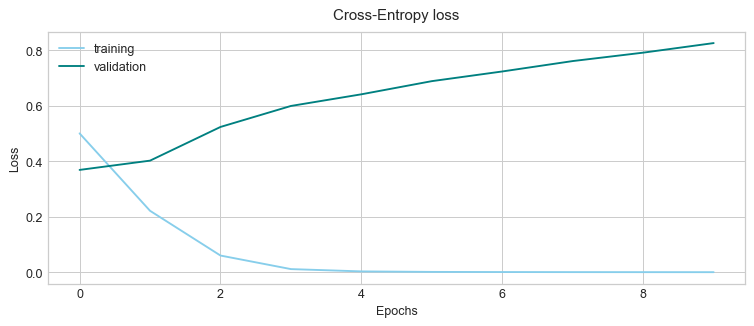

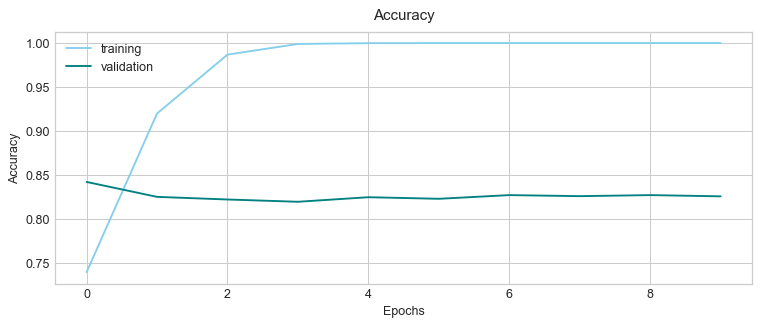

In [21]:
plots(hist)

## Notes:

- Validation accuracy stays stable throughout the model fitting.
- though the loss on validation reaches the sky.
- During the otpimaztion gradients of the model overshoots. thats the reason for high increasing error.
- Fine tune model.
- Model is overfitting in short.

__" your model is predicting correct, but it's less sure about it. This is how you get high accuracy and high loss "__

## Fine Tuning Architecture: Trial & Error approach

In [22]:
%%timeit
%%capture
net = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, 'relu'),
    tf.keras.layers.Dropout(0.7),
    # tf.keras.layers.Dense(64, 'relu'),
    tf.keras.layers.Dense(32, 'relu'),
    tf.keras.layers.Dense(1, 'sigmoid')
])

net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

experiece = net.fit(padded, train_label, validation_data=(val_padded, val_label), epochs=10)

19.9 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


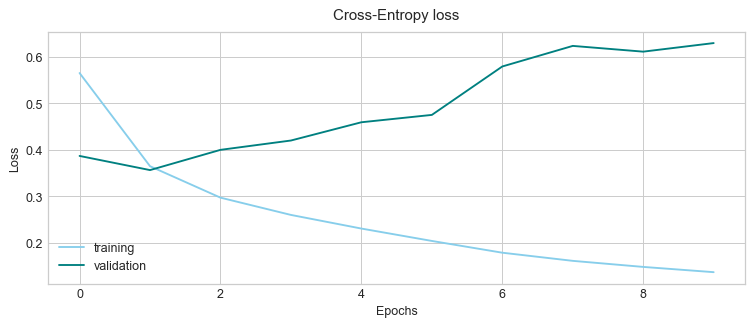

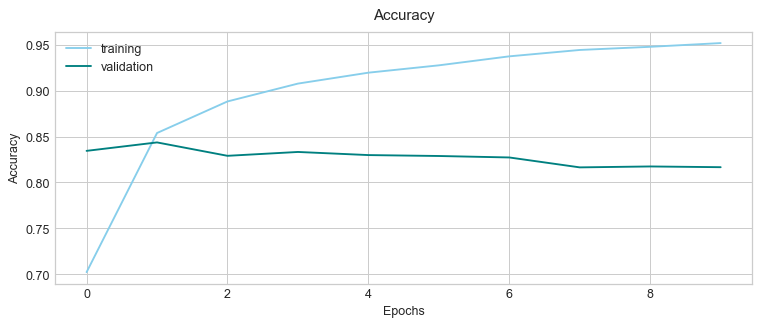

In [27]:
exp = pd.DataFrame(experiece.history)
plots(exp)

- Results are not that great..
- Fix the problems.
- Fine tune network architecture.

In [28]:
del net, experiece

In [29]:
%%timeit
%%capture
network = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    # tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, 'relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(64, 'relu'),
    # tf.keras.layers.Dense(32, 'relu'),
    # tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, 'sigmoid')
])
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lookup = network.fit(padded, train_label,validation_data=(val_padded, val_label), epochs=10)

23.3 s ± 581 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


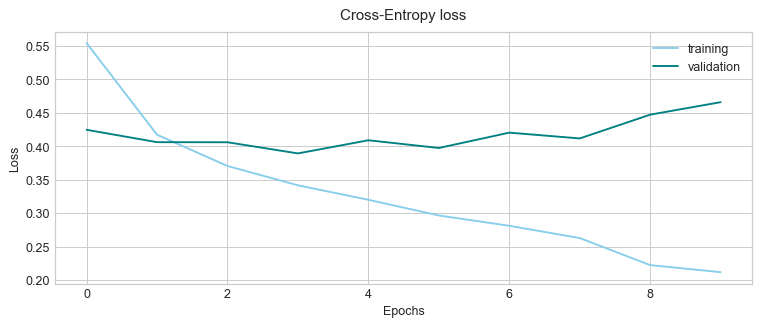

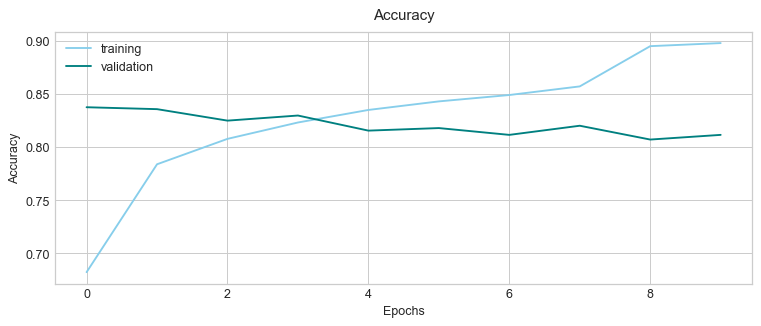

In [31]:
lookup_ = pd.DataFrame(lookup.history)
plots(lookup_)

## Note:

- Validation loss kept increasing if we run the model over 50 epochs of training.
- Model is etremely unstable (overfitting).
- Model can be improved.

In [ ]:
del network, lookup

In [ ]:
# imdb_csv = pd.DataFrame({'reviews': train_sent, 'labels': train_label})
# imdb_csv.head(10)

In [ ]:
# imdb_csv.labels.value_counts(normalize=True).plot.bar(color=['teal', 'skyblue']);